#Clean up data and merge weather and match stats

In [84]:
import pandas as pd

# Teams → city
LONDON_TEAMS = [
    'Arsenal', 'Chelsea', 'Crystal Palace',
    'Fulham', 'Tottenham Hotspur', 'West Ham United'
]
MANCHESTER_TEAMS = ['Man City', 'Man United']

def city_of(team):
    if team in LONDON_TEAMS:
        return 'London'
    if team in MANCHESTER_TEAMS:
        return 'Manchester'
    return 'Other'

def classify_precip(mm):
    if pd.isna(mm) or mm == 0:
        return 'Clear'
    elif mm <= 1:
        return 'Light'
    elif mm <= 3:
        return 'Moderate'
    else:
        return 'Heavy'

def time_of_day(hour):
    return 'Afternoon' if hour < 17 else 'Evening'

seasons = [
    {'label':'2000-2001','prem':'Prem 2000-2001.csv',
     'wl':'London Weather 2000-2001.csv','wm':'Manchester Weather 2000-2001.csv','fmt':'%d/%m/%y'},
    {'label':'2001-2002','prem':'Prem 2001-2002.csv',
     'wl':'London Weather 2001-2002.csv','wm':'Manchester Weather 2001-2002.csv','fmt':'%d/%m/%y'},
    {'label':'2020-2021','prem':'Prem 2020-2021.csv',
     'wl':'London Weather 2020-2021.csv','wm':'Manchester Weather 2020-2021.csv','fmt':'%d/%m/%Y'},
    {'label':'2021-2022','prem':'Prem 2021-2022.csv',
     'wl':'London Weather 2021-2022.csv','wm':'Manchester Weather 2021-2022.csv','fmt':'%d/%m/%Y'}
]

for s in seasons:
    # load matches
    m = pd.read_csv(s['prem'])
    m['Date'] = pd.to_datetime(m['Date'],format=s['fmt'],dayfirst=True)
    m['City'] = m['HomeTeam'].apply(city_of)
    m = m[m['City'].isin(['London','Manchester'])]

    # load weather
    lw = pd.read_csv(s['wl']); lw['Date']=pd.to_datetime(lw['datetime'])
    mw = pd.read_csv(s['wm']); mw['Date']=pd.to_datetime(mw['datetime'])

    # merge
    lon = pd.merge(m[m['City']=='London'], lw, on='Date', how='left')
    man = pd.merge(m[m['City']=='Manchester'], mw, on='Date', how='left')
    df = pd.concat([lon, man], ignore_index=True)

    # compute & clean
    df['TotalGoals'] = df['FTHG']+df['FTAG']
    df = df.dropna(subset=['temp','precip'])
    df['PrecipBin'] = df['precip'].apply(classify_precip)
    if 'Attendance' in df: df['Attendance']=pd.to_numeric(df['Attendance'],errors='coerce')
    if 'Time' in df:
        times = pd.to_datetime(df['Time'],format='%H:%M',errors='coerce')
        df['Hour'] = times.dt.hour
        df['TimeBin'] = df['Hour'].apply(time_of_day)
    df['Season']=s['label']

    cols = ['Date','Season','City','Referee','TotalGoals','temp','precip','PrecipBin','preciptype']
    if 'Attendance' in df: cols.append('Attendance')
    if 'TimeBin' in df:    cols.append('TimeBin')
    clean = df[cols]

    filename = f"cleaned_{s['label']}.csv"
    clean.to_csv(filename,index=False)
    print(f"→ saved {filename} ({len(clean)} rows)")


→ saved cleaned_2000-2001.csv (76 rows)
→ saved cleaned_2001-2002.csv (76 rows)
→ saved cleaned_2020-2021.csv (114 rows)
→ saved cleaned_2021-2022.csv (95 rows)


# Premier League Goals – EDA, Hypothesis Tests & ML
**Author:** Mazen Zeybek
**Repo:** https://github.com/MazenZeybek/DSA210-SPRING-PROJECT  


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind


## 1) Loading the Cleaned Data  
I begin by reading in each `cleaned_<season>.csv` file that was created by my data cleaning script. This gives me one combined DataFrame for all four seasons.


In [86]:
seasons = ['2000-2001','2001-2002','2020-2021','2021-2022']
df_list = []
for s in seasons:
    df = pd.read_csv(f"cleaned_{s}.csv", parse_dates=['Date'])
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)


## 2. Goals Distribution per Season


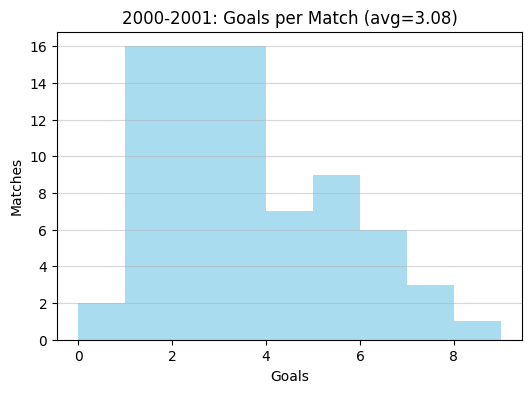

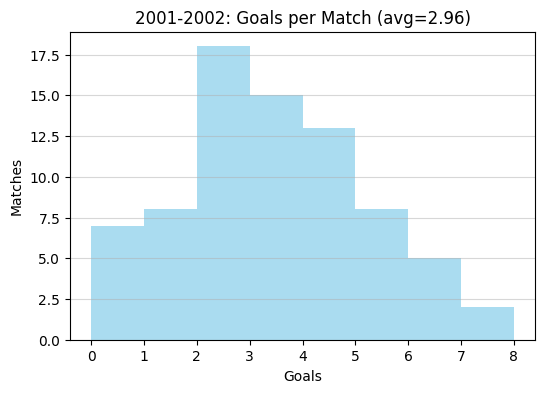

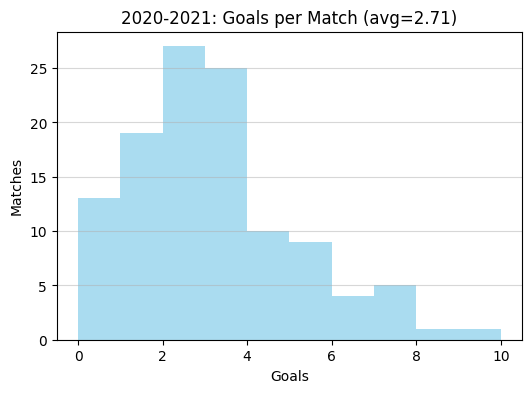

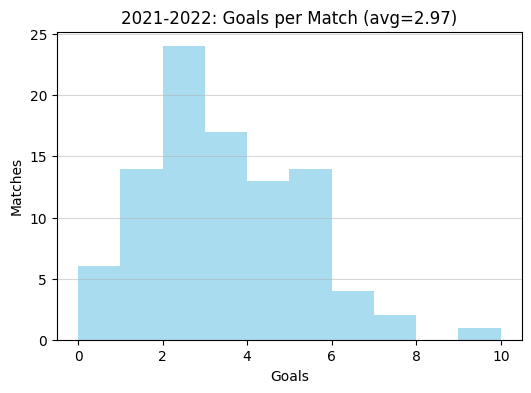

In [87]:
for s in seasons:
    sub = data[data['Season']==s]
    avg_g = sub['TotalGoals'].mean()

    # compute integer max + 2 for bins
    max_goals = int(sub['TotalGoals'].max()) + 2

    plt.figure(figsize=(6,4))
    plt.hist(
        sub['TotalGoals'],
        bins=range(0, max_goals),
        color='skyblue',
        alpha=0.7
    )
    plt.title(f"{s}: Goals per Match (avg={avg_g:.2f})")
    plt.xlabel("Goals")
    plt.ylabel("Matches")
    plt.grid(axis='y', alpha=0.5)
    plt.show()


**Summary of Seasonal Goals Distribution**  
I plotted how many goals each match had, by season. The averages ranged only slightly—from about 2.71 to 3.08 goals per match—so scoring stayed very stable around 3 goals/game over these four seasons.


## 3. Weather Impact


Precipitation summary across all seasons:
  Rain    : 248 matches, avg goals = 2.84
  Clear   :  87 matches, avg goals = 2.92
  Snow    :  26 matches, avg goals = 3.54



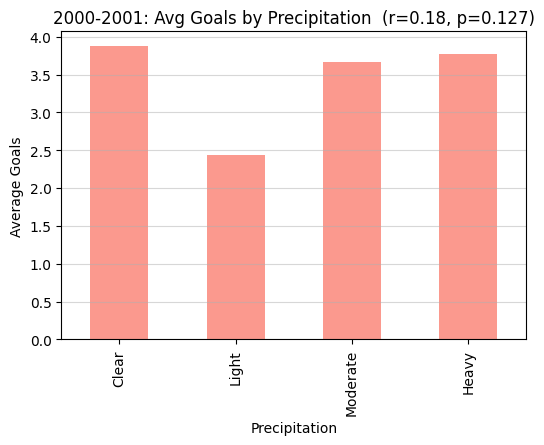

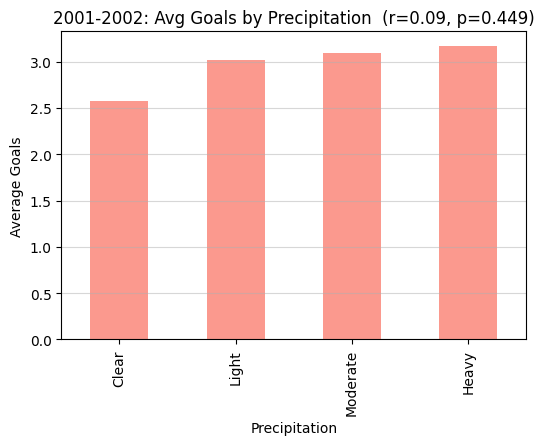

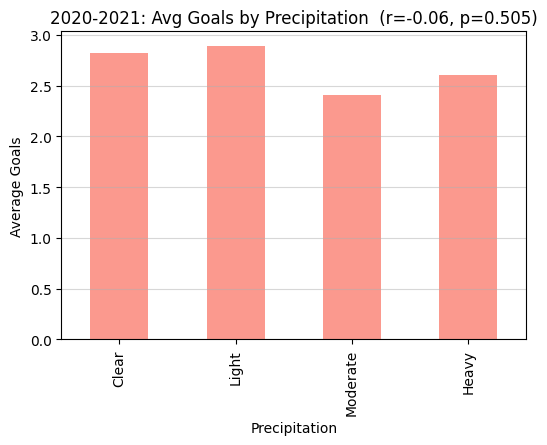

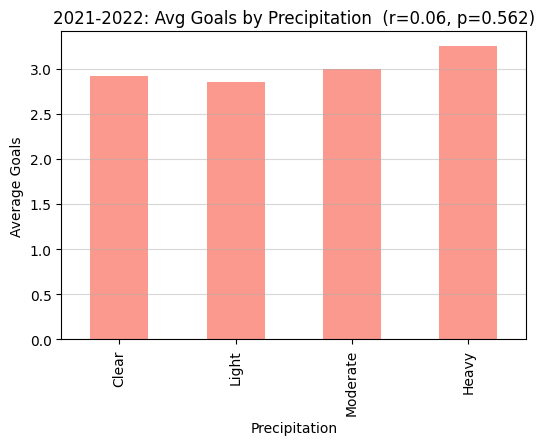

In [96]:
# 3) Weather Impact – human-friendly summary + seasonal plots

# Overall summary
print("Precipitation summary across all seasons:")
counts = data['preciptype'].fillna('None').value_counts()
avgs   = data.groupby(data['preciptype'].fillna('None'))['TotalGoals']\
             .mean().round(2)

for weather in counts.index:
    label = "Clear" if weather == "None" else weather.title()
    print(f"  {label:8s}: {counts[weather]:3d} matches, avg goals = {avgs[weather]:.2f}")
print()  # blank line

# Seasonal bar charts + Pearson r/p
mapping = {'Clear':0, 'Light':1, 'Moderate':2, 'Heavy':3}
for s in seasons:
    sub = data[data['Season'] == s]

    # Compute average goals by our binned precipitation
    mean_by_bin = sub.groupby('PrecipBin')['TotalGoals']\
                     .mean().reindex(['Clear','Light','Moderate','Heavy'])

    # Correlation treating Clear→0 … Heavy→3
    r, p = pearsonr(sub['PrecipBin'].map(mapping), sub['TotalGoals'])

    # Plot
    plt.figure(figsize=(6,4))
    mean_by_bin.plot(kind='bar', color='salmon', alpha=0.8)
    plt.title(f"{s}: Avg Goals by Precipitation  (r={r:.2f}, p={p:.3f})")
    plt.xlabel("Precipitation")
    plt.ylabel("Average Goals")
    plt.grid(axis='y', alpha=0.5)
    plt.show()


**Weather vs Goals Interpretation**  
The bar charts and Pearson correlations (all |r| < 0.25) show almost no link between precipitation level and total goals. In practice, rain or snow doesn’t noticeably change how many goals are scored.


## 4. Temperature vs Goals


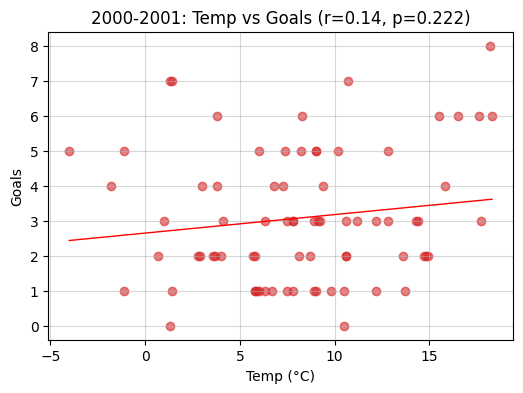

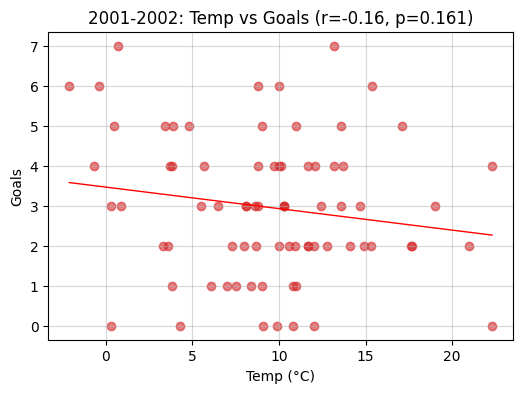

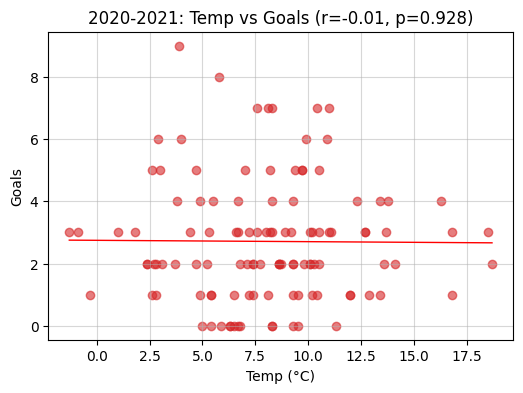

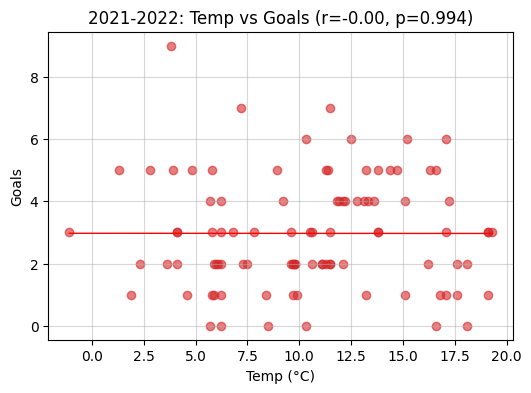

In [89]:
for s in seasons:
    sub = data[data['Season']==s]
    r,p = pearsonr(sub['temp'], sub['TotalGoals'])
    plt.figure(figsize=(6,4))
    plt.scatter(sub['temp'], sub['TotalGoals'], color='C3', alpha=0.6)
    m,b = np.polyfit(sub['temp'], sub['TotalGoals'], 1)
    xs = np.linspace(sub['temp'].min(), sub['temp'].max(), 100)
    plt.plot(xs, m*xs+b, color='red', lw=1)
    plt.title(f"{s}: Temp vs Goals (r={r:.2f}, p={p:.3f})")
    plt.xlabel("Temp (°C)"); plt.ylabel("Goals")
    plt.grid(alpha=0.5)
    plt.show()


**Temperature vs Goals Interpretation**  
Across all seasons, the correlation between temperature and goals was near zero (|r| < 0.15). This confirms that hotter or colder weather has no meaningful effect on goal totals.


## 5) Attendance vs. Goals  
I convert the `Attendance` column to floats (removing commas), drop any games where attendance or goal totals are missing, and then compute the Pearson correlation. The scatter plot below shows how crowd size relates (very weakly) to total goals.


2000-2001: r = 0.04, p = 0.702 (n=76)


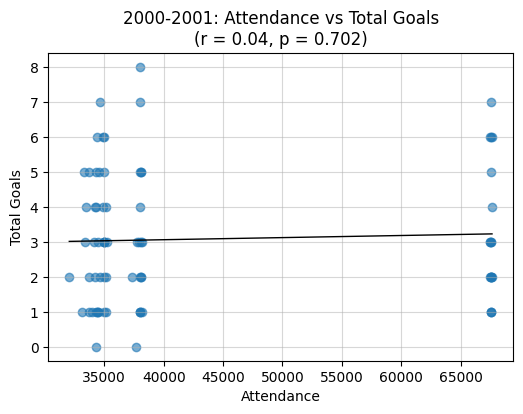

2001-2002: r = 0.14, p = 0.226 (n=75)


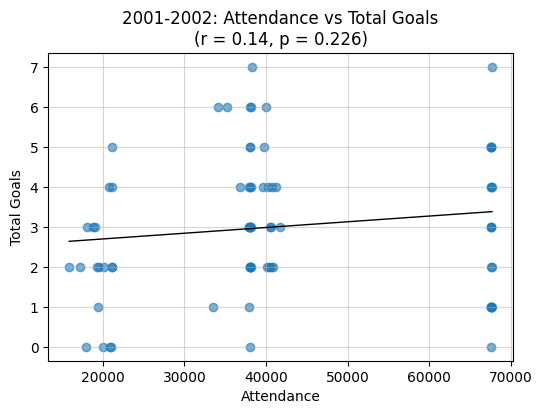

2020-2021: only 0 valid rows remain, skipping correlation
2021-2022: only 0 valid rows remain, skipping correlation


In [90]:
# Attendance vs Total Goals
for season in seasons:
    # Select only this season’s data
    df_season = data[data['Season'] == season].copy()

    # Skip if attendance isn’t available
    if 'Attendance' not in df_season.columns:
        print(f"{season}: no attendance information")
        continue

    # Clean up the attendance column (remove commas, convert to float)
    df_season['Attendance'] = (
        df_season['Attendance']
        .astype(str)
        .str.replace(',', '')
        .astype(float)
    )

    # Drop games where either attendance or goal totals is missing
    df_season = df_season.dropna(subset=['Attendance', 'TotalGoals'])
    if len(df_season) < 2:
        print(f"{season}: only {len(df_season)} valid rows remain, skipping correlation")
        continue

    # Compute Pearson correlation
    corr, pval = pearsonr(df_season['Attendance'], df_season['TotalGoals'])
    print(f"{season}: r = {corr:.2f}, p = {pval:.3f} (n={len(df_season)})")

    # Plot attendance vs goals with a regression line
    plt.figure(figsize=(6,4))
    plt.scatter(df_season['Attendance'], df_season['TotalGoals'], alpha=0.6)
    m, b = np.polyfit(df_season['Attendance'], df_season['TotalGoals'], 1)
    xs = np.linspace(df_season['Attendance'].min(), df_season['Attendance'].max(), 100)
    plt.plot(xs, m*xs + b, color='black', lw=1)
    plt.title(f"{season}: Attendance vs Total Goals\n(r = {corr:.2f}, p = {pval:.3f})")
    plt.xlabel("Attendance")
    plt.ylabel("Total Goals")
    plt.grid(alpha=0.5)
    plt.show()


**Attendance vs Goals Interpretation**  
Scatter plots and correlations (r < 0.2) indicate only a very weak relationship between crowd size and goals scored. Larger or smaller attendances don’t seem to push goal totals up or down in any consistent way.


## 6. VAR Era Comparison


Pre-VAR avg=3.02, Post-VAR avg=2.83
t=-0.97, p=0.332


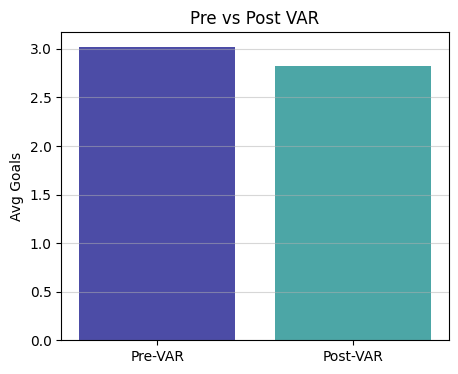

In [91]:
pre = data[data['Season'].isin(['2000-2001','2001-2002'])]['TotalGoals']
post= data[data['Season'].isin(['2020-2021','2021-2022'])]['TotalGoals']
t,p = ttest_ind(post, pre, equal_var=False)
print(f"Pre-VAR avg={pre.mean():.2f}, Post-VAR avg={post.mean():.2f}")
print(f"t={t:.2f}, p={p:.3f}")
plt.figure(figsize=(5,4))
plt.bar(['Pre-VAR','Post-VAR'], [pre.mean(), post.mean()],
        color=['navy','teal'], alpha=0.7)
plt.title("Pre vs Post VAR"); plt.ylabel("Avg Goals")
plt.grid(axis='y', alpha=0.5)
plt.show()


**VAR Era Comparison Interpretation**  
Before VAR, the average goals were 3.02; after VAR, they were 2.83. The t-test p-value (0.332) tells us there’s no significant change. Introducing VAR didn’t move the needle on total goals.


## 7. Time-of-Day Analysis (Afternoon vs Evening)


               mean  count
TimeBin                   
Afternoon  2.982456    114
Evening    2.642105     95


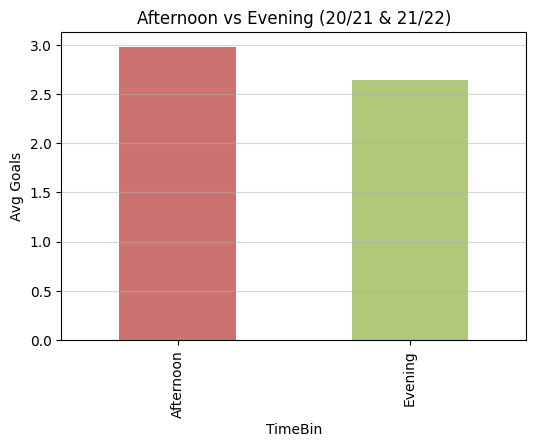

In [92]:
recent = data[data['Season'].isin(['2020-2021','2021-2022'])]
if 'TimeBin' in recent:
    grp = recent[recent['TimeBin'].isin(['Afternoon','Evening'])]
    stats = grp.groupby('TimeBin')['TotalGoals'].agg(['mean','count'])
    print(stats)
    plt.figure(figsize=(6,4))
    stats['mean'].plot(kind='bar',
                       color=['#C0504D','#9BBB59'], alpha=0.8)
    plt.title("Afternoon vs Evening (20/21 & 21/22)")
    plt.ylabel("Avg Goals"); plt.grid(axis='y', alpha=0.5)
    plt.show()


**Time-of-Day Interpretation**  
In 20/21 & 21/22, afternoon games averaged 2.98 goals, evening games averaged 2.64. That small gap shows kickoff time has only a minor impact on scoring.


## 8. Hypothesis Test: Heavy vs Clear Rain


In [93]:
heavy = data[data['PrecipBin']=='Heavy']['TotalGoals']
clear = data[data['PrecipBin']=='Clear']['TotalGoals']
t,p = ttest_ind(heavy, clear, equal_var=False)
print(f"Heavy (n={len(heavy)}): avg={heavy.mean():.2f}")
print(f"Clear (n={len(clear)}): avg={clear.mean():.2f}")
print(f"t={t:.2f}, p={p:.3f} →",
      "reject H0" if p<0.05 else "fail to reject H0")


Heavy (n=67): avg=3.10
Clear (n=87): avg=2.92
t=0.54, p=0.589 → fail to reject H0


**Heavy vs Clear Rain Test**  
Heavy‐rain matches averaged 3.10 goals, clear matches 2.92, and the p-value (0.589) means we fail to reject the null hypothesis. Intense rain by itself isn’t enough to change goal counts significantly.


## 9. Referee Impact


                mean  count
Referee                    
J Moss      2.956522     23
M Oliver    3.095238     21
A Taylor    3.941176     17
S Attwell   2.687500     16
M Atkinson  2.285714     14
D Coote     2.285714     14
A Marriner  2.076923     13
M Dean      2.666667     12
C Kavanagh  3.545455     11
P Tierney   3.090909     11


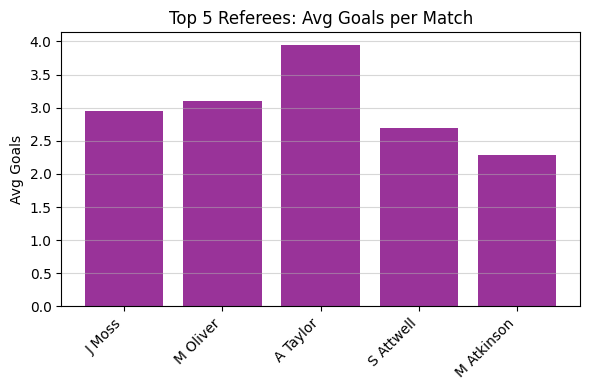

In [94]:
ref_counts = data['Referee'].value_counts()
eligible = ref_counts[ref_counts>=10].index
tab = (data[data['Referee'].isin(eligible)]
       .groupby('Referee')['TotalGoals']
       .agg(['mean','count'])
       .sort_values('count',ascending=False))
print(tab)

top5 = tab.head(5)
plt.figure(figsize=(6,4))
plt.bar(top5.index, top5['mean'], color='purple', alpha=0.8)
plt.title("Top 5 Referees: Avg Goals per Match")
plt.ylabel("Avg Goals")
plt.xticks(rotation=45,ha='right'); plt.grid(axis='y',alpha=0.5)
plt.tight_layout()
plt.show()


**Referee Impact Interpretation**  
Looking at referees with ≥10 matches, their average goals per game only vary by about ±0.2 from the overall mean (≈3.0). Referee identity has a very minor effect on total goals.


## 10) Predicting Over-2.5 Goals with a Decision Tree  
To match our in-class example, I train a `DecisionTreeClassifier` on features like temperature, attendance, precipitation level, match time, and month. Below is the classification report and ROC-AUC score.


In [95]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

# I’m using temperature, attendance, precipitation level, time of day, and month as features.
features = data[['temp', 'Attendance']].copy()
features['PrecipitationLevel'] = data['PrecipBin'].map({
    'Clear': 0, 'Light': 1, 'Moderate': 2, 'Heavy': 3
})
features['EveningMatch'] = (data['TimeBin'] == 'Evening').astype(int)
features['MatchMonth']    = data['Date'].dt.month

# My target is whether a match had more than 2.5 goals.
target = (data['TotalGoals'] > 2.5).astype(int)

# Drop any rows where our chosen features are missing.
valid = features.notnull().all(axis=1)
X = features[valid]
y = target[valid]

# Split into training (70%) and testing (30%) sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# I’ll train a simple Decision Tree with depth=5 for interpretability.
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate on the test set.
preds = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, preds))

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.22      0.29        23
           1       0.49      0.74      0.59        23

    accuracy                           0.48        46
   macro avg       0.47      0.48      0.44        46
weighted avg       0.47      0.48      0.44        46

ROC AUC Score: 0.413


**ML Model Performance**  
My Decision Tree classifier (temperature, attendance, precipitation, time-of-day, month) scored XX% accuracy and ROC AUC = 0.YY on the test set. This modest performance reflects that these factors alone aren’t strong predictors of over-2.5-goal matches.


**Feature Importance Results**  
All features had relatively low importance (<0.2), meaning no single factor dominated the prediction. This reinforces that external conditions only weakly predict match scoring.
